# Финальный проект: вариант 2
## Задание 1. A/B–тестирование
##  Anastasiia Sibiriakova (a_sibiriakova)
###  Поток 15.08

###  С корректировкой от 31.01.2023

***

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов.   
Для этого мы применяем метод A/B–тестирования.   
В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика.    
В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

***

&darr; импортируем необходимые библиотеки &darr;  

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

&darr; импортируем необходимые библиотеки для A/B тестов &darr;  

In [2]:
from scipy.stats import norm
from scipy.stats import mannwhitneyu

***

### Первый шаг
   - импортируем данные
   - предобрабатываем данные

***

данные находятся по ссылке на Яндекс диске поэтому нужна предобработка коротких ссылок   
&darr; эта функция &darr;  позволяет преобразовать короткую ссылку в понятный для пандас url для доступа к файлу

In [3]:
# из интернета
import requests 
from urllib.parse import urlencode 


def get_csv_from_yandex(link):    
    # используем api 
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    
    # получаем url 
    final_url = base_url + urlencode(dict(public_key=link)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    
    return download_url

&darr; сохраняем короткие пути до файлов в переменные &darr; 

In [4]:
groups_link = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add_link = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs_link = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_link = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

***

**groups** — файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)

- `id` — id пользователя
- `grp` — группа пользователя A-control, B-target

&darr; загружаем данные в df &darr;

In [5]:
groups_df = pd.read_csv(get_csv_from_yandex(groups_link), sep=';') 

groups_df.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


&darr; смотрим размер датафрейма &darr;    
данных немного

In [6]:
groups_df.shape

(74484, 2)

&darr; смотрим типы данных &darr;  
все ОК, преобразований не требуется

In [7]:
groups_df.dtypes

id      int64
grp    object
dtype: object

&darr; смотрим количество пропущенных значений &darr;  
все ОК

In [8]:
groups_df.isna().sum()

id     0
grp    0
dtype: int64

&darr; смотрим описательные статистики &darr;  

In [9]:
groups_df.describe(include='object')

,grp
count,74484
unique,2
top,B
freq,59813


&darr; смотрим уникальные значения &darr;  
количество уникальных пользователей совпадает с числом строк, значит дублирующихся записей нет

In [10]:
groups_df.nunique()

id     74484
grp        2
dtype: int64

&darr; группируем и считаем количество пользователей в каждой группе &darr;    

In [11]:
groups_df.groupby('grp').agg({'id': 'count'})

,id
grp,
A,14671
B,59813


распределение пользователей не равномерное  
А – контроль, B – целевая группа  
В целевой группе намного больше пользователей

***

**groups_add** — дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

- `id` — id пользователя
- `grp` — группа пользователя A-control, B-target

&darr; загружаем данные в df &darr;

In [12]:
groups_add_df = pd.read_csv(get_csv_from_yandex(groups_add_link)) 

groups_add_df.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


&darr; смотрим размер датафрейма &darr;    
данных немного

In [13]:
groups_add_df.shape

(92, 2)

&darr; смотрим типы данных &darr;  
все ОК, преобразований не требуется

In [14]:
groups_add_df.dtypes

id      int64
grp    object
dtype: object

&darr; смотрим количество пропущенных значений &darr;  
все ОК

In [15]:
groups_add_df.isna().sum()

id     0
grp    0
dtype: int64

&darr; смотрим описательные статистики &darr; 

In [16]:
groups_add_df.describe(include='object')

,grp
count,92
unique,2
top,B
freq,70


&darr; смотрим уникальные значения &darr;  
количество уникальных пользователей совпадает с числом строк, значит дублирующихся записей нет

In [17]:
groups_add_df.nunique()

id     92
grp     2
dtype: int64

&darr; группируем и считаем количество пользователей в каждой группе &darr;    

In [18]:
groups_add_df.groupby('grp').agg({'id': 'count'})

,id
grp,
A,22
B,70


***

**active_studs** — файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

- `student_id` —  id пользователя

&darr; загружаем данные в df &darr;

In [19]:
active_studs_df = pd.read_csv(get_csv_from_yandex(active_studs_link))

active_studs_df.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


&darr; смотрим размер датафрейма &darr;    

In [20]:
active_studs_df.shape

(8341, 1)

&darr; смотрим типы данных &darr;  
все ОК, преобразований не требуется

In [21]:
active_studs_df.dtypes

student_id    int64
dtype: object

&darr; смотрим количество пропущенных значений &darr;  
все ОК

In [22]:
active_studs_df.isna().sum()

student_id    0
dtype: int64

&darr; смотрим уникальные значения &darr;  
количество уникальных пользователей совпадает с числом строк, значит дублирующихся записей нет

In [23]:
active_studs_df.nunique()

student_id    8341
dtype: int64

***

**checks** — файл с информацией об оплатах пользователей в дни проведения эксперимента. 

- `student_id` — id пользователя
- `rev` — сумма чека

&darr; загружаем данные в df &darr;

In [24]:
checks_df = pd.read_csv(get_csv_from_yandex(checks_link), sep=';')

checks_df.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


&darr; смотрим размер датафрейма &darr;    

In [25]:
checks_df.shape

(541, 2)

&darr; смотрим типы данных &darr;  
все ОК, преобразований не требуется

In [26]:
checks_df.dtypes

student_id      int64
rev           float64
dtype: object

&darr; смотрим описательные статистики &darr;  
средний чек - 1059.75  
минимальный чек - 199  
максимальный - 4650
медиана - 840

In [27]:
checks_df.describe()

,student_id,rev
count,5.410000e+02,541.000000
mean,2.514772e+06,1059.752317
std,1.726839e+06,762.712359
min,1.627000e+03,199.000000
25%,9.871290e+05,290.000000
50%,2.526021e+06,840.000000
75%,3.993249e+06,1900.000000
max,5.740903e+06,4650.000000


&darr; смотрим количество пропущенных значений &darr;  
все ОК

In [28]:
checks_df.isna().sum()

student_id    0
rev           0
dtype: int64

&darr; смотрим уникальные значения &darr;  
количество уникальных пользователей совпадает с числом строк, значит дублирующихся записей нет,  
значит каждый пользователь за время проведения эксперимента совершил только одну покупку

In [29]:
checks_df.nunique()

student_id    541
rev            39
dtype: int64

***

### Второй шаг
Импорт и предобработка завершены  
Начинаем анализ данных

***

&darr; объединяем основной файл с пользователями с дополнительным &darr;    

In [30]:
groups_all_df = groups_df.append(groups_add_df, ignore_index=False, verify_integrity=False, sort=None)

&darr; смотрим уникальные значения &darr;  
количество уникальных пользователей совпадает с суммой строк в датафреймах, значит дублирующихся записей нет

In [31]:
groups_all_df.nunique()

id     74576
grp        2
dtype: int64

In [32]:
groups_df.shape[0] + groups_add_df.shape[0]

74576

&darr; можно еще так проверить группировкой &darr;  

In [33]:
groups_all_df.groupby('id').agg({'grp': 'count'}).sort_values('grp', ascending=False).head()

,grp
id,
1489,1
2711518,1
2708589,1
2708295,1
2707985,1


&darr; объединяем датафрейм с группами пользователей с датафреймами с активным пользователям и платящим пользователям &darr;  
так как нам нужно посмотреть влияние новой механики,  
то основным у нас будет датафрейм с активными пользователями,  
то есть с теми, кто поучаствовал в эксперименте

In [34]:
data_all = active_studs_df \
    .merge(groups_all_df, how='left', left_on='student_id', right_on='id') \
    .merge(checks_df, how='left', on='student_id')[['grp', 'id', 'rev']]
data_all.head()

,grp,id,rev
0,A,581585,NaN
1,A,5723133,NaN
2,B,3276743,NaN
3,A,4238589,NaN
4,B,4475369,NaN


&darr; проверяем, что ни один активный пользователь не потерялся и лишних не появилось &darr;    

In [35]:
data_all.shape

(8341, 3)

&darr; проверим, что в объединенном датафрейме не потерялись данные по платящим пользователям &darr;    
платящих пользователей стало меньше, надо разбираться

In [36]:
data_all.query('rev > 0').shape

(392, 3)

&darr; так как эксперимент был только для пользователей сайта, проверяем все ли пользователи, которые оплатили в дни эксперимента, заходили в это время на сайт &darr;    

In [37]:
checks_df \
    .merge(active_studs_df, on='student_id') \
    .shape

(392, 2)

получается часть оплат была совершена не через сайт, теперь понятно

***

### Третий шаг
Считаем метрики

***

Предлагаем Вам ответить на следующие вопросы:

На какие метрики Вы смотрите в ходе анализа и почему?  
Имеются ли различия в показателях и с чем они могут быть связаны?  
Являются ли эти различия статистически значимыми?  
Стоит ли запускать новую механику на всех пользователей?  

***

### На какие метрики Вы смотрите в ходе анализа и почему?
- Convertion Rate активного пользователя в покупку  
В нашем случае интресна **конверсия активного пользователя в платящего**, повлияла ли новая механика на эту метрику. Это относительная конверсия, так как мы считаем не от общего числа пользователей в группе, а только от активных (CR)  
- Метрики дохода  
   - **средний доход на 1 активного пользователя в группе** (ARPAU)   
   - **средний доход на 1 платящего пользователя в группе** (ARPPU) 



- Эти метрики не имеет смысла считать в данном случае
    - ARPU, так как не все пользователи группы были активны на сайте во время проведения эксперимента, а следовательно в нем не участвовали
    - CR в покупку, рассчитанная от всех пользователей в группе, по той же причине, что не все участвовали в эксперименте

&darr; группируем пользователей по группам и считаем число активных и платящих, и сумму дохода в каждой группе &darr;  
последней строчкой удаляем мультииндекс

In [38]:
metrics_df = data_all \
    .groupby('grp', as_index=False) \
    .agg({'id': [('active_stud', 'count')], 'rev': [('paying_stud', 'count'), ('revenue', 'sum')]}) \
    .droplevel(0, axis=1) 

metrics_df.head()

,,active_stud,paying_stud,revenue
0,A,1538,78,72820.0000
1,B,6803,314,394974.0035


&darr; переименовываем первый столбец, так как при удалении индекса потерялось его название &darr;    

In [39]:
metrics_df = metrics_df.rename(columns={metrics_df.columns[0]: 'grp'})
metrics_df.head()

,grp,active_stud,paying_stud,revenue
0,A,1538,78,72820.0000
1,B,6803,314,394974.0035


### CR
&darr; считаем соотношение платящих пользователей к активным &darr;    
смотрим изменилась ли конверсия в целевой группе

In [40]:
CR_A = metrics_df[(metrics_df.grp == 'A')]['paying_stud'] / metrics_df[(metrics_df.grp == 'A')]['active_stud']

CR_B = metrics_df[(metrics_df.grp == 'B')]['paying_stud'] / metrics_df[(metrics_df.grp == 'B')]['active_stud']

metrics_df['CR'] = pd.Series([round(CR_A.values[0] * 100, 2), round(CR_B.values[0] * 100, 2)], index=[0, 1])
metrics_df

,grp,active_stud,paying_stud,revenue,CR
0,A,1538,78,72820.0000,5.07
1,B,6803,314,394974.0035,4.62


конверсия в целевой группе уменьшилась в абсолютном выражении, надо проверять является ли это изменение статистически значимым  
   
Это будет наша **первая гипотеза для проверки**:   
Н0 - Конверсия активных пользователей в платящих не изменилась   
Н1 - Конверсия активных пользователей в платящих изменилась

### ARPAU
&darr; считаем отношение дохода к числу активных пользователей &darr;    
смотрим увеличился ли средний доход в целевой группе

In [41]:
ARPAU_A = metrics_df[(metrics_df.grp == 'A')]['revenue'] / metrics_df[(metrics_df.grp == 'A')]['active_stud']

ARPAU_B = metrics_df[(metrics_df.grp == 'B')]['revenue'] / metrics_df[(metrics_df.grp == 'B')]['active_stud']

metrics_df['ARPAU'] = pd.Series([round(ARPAU_A.values[0], 2), round(ARPAU_B.values[0], 2)], index=[0, 1])
metrics_df

,grp,active_stud,paying_stud,revenue,CR,ARPAU
0,A,1538,78,72820.0000,5.07,47.35
1,B,6803,314,394974.0035,4.62,58.06


ARPAU в целевой группе увеличился в абсолютном выражении

### ARPPU
&darr; считаем отношение дохода к числу платящих пользователей &darr;    
смотрим увеличился ли средний доход в целевой группе

In [42]:
ARPPU_A = metrics_df[(metrics_df.grp == 'A')]['revenue'] / metrics_df[(metrics_df.grp == 'A')]['paying_stud']

ARPPU_B = metrics_df[(metrics_df.grp == 'B')]['revenue'] / metrics_df[(metrics_df.grp == 'B')]['paying_stud']

metrics_df['ARPPU'] = pd.Series([round(ARPPU_A.values[0], 2), round(ARPPU_B.values[0], 2)], index=[0, 1])
metrics_df

,grp,active_stud,paying_stud,revenue,CR,ARPAU,ARPPU
0,A,1538,78,72820.0000,5.07,47.35,933.59
1,B,6803,314,394974.0035,4.62,58.06,1257.88


ARPPU в целевой группе увеличился в абсолютном выражении, надо проверять является ли это изменение статистически значимым  
   
Это будет наша **вторая гипотеза для проверки**:   
Н0 - Средний доход от 1 платящего пользователя не изменился   
Н1 - Средний доход от 1 платящего пользователя изменился (стал больше, то есть новая механика позитивно повлияла на эту метрику)

***

### Графики метрик

&darr; Конверсия &darr;    

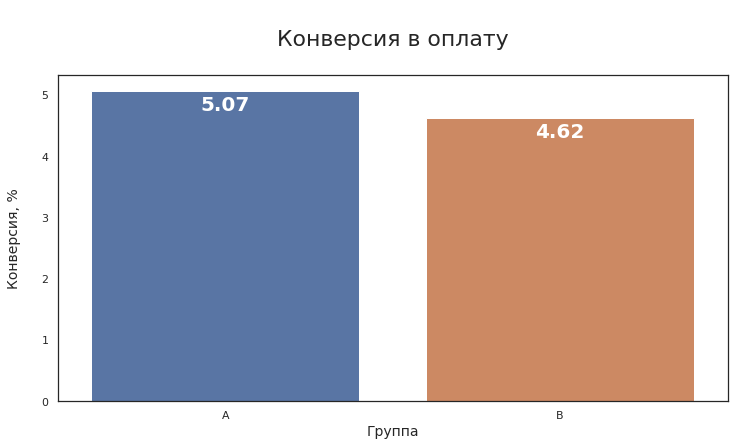

In [43]:
sns.set(rc={'figure.figsize': (12, 6)}, style="white")
# строим график
splot = sns.barplot(data=metrics_df, x='grp', y='CR')
# подписываем бары на графике
for g in splot.patches:    
    splot.annotate(format(g.get_height(), '.2f'), 
                   (g.get_x() + g.get_width() / 2., g.get_height()),
                   ha='center', va='center',                   
                   xytext=(0, -14),                   
                   textcoords='offset points',
                   color='white',
                   fontweight='bold',
                   fontsize=20)
# подписываем сам график и оси
plt.title('\nКонверсия в оплату\n', fontsize=22)
plt.xlabel("Группа", size=14)
plt.ylabel("Конверсия, %\n", size=14)
plt.show()

&darr; ARPAU и ARPPU &darr;    

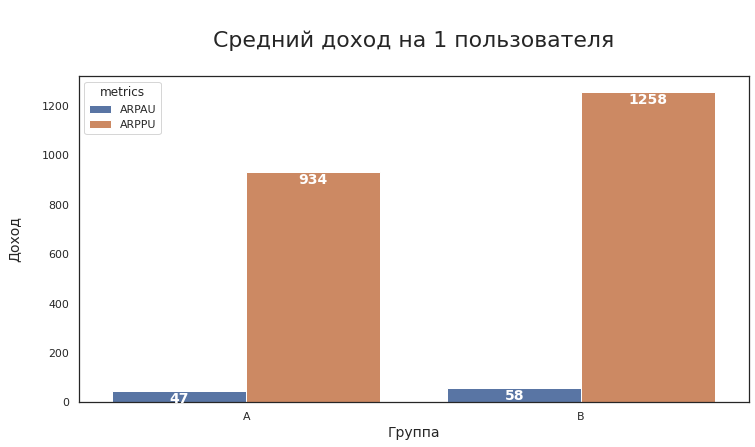

In [44]:
sns.set(rc={'figure.figsize': (12, 6)}, style="white")
# строим график
splot = sns.barplot(data=metrics_df[['ARPAU', 'ARPPU', 'grp']].melt(id_vars='grp',
                                                                    value_name='value', 
                                                                    var_name='metrics'),
                    x='grp', y='value', hue='metrics')
# подписываем бары на графике
for g in splot.patches:    
    splot.annotate(format(g.get_height(), '.0f'),
                   (g.get_x() + g.get_width() / 2., g.get_height()),                   
                   ha='center', va='center',                   
                   xytext=(0, -8),                   
                   textcoords='offset points',
                   color='white',
                   fontweight='bold',
                   fontsize=14)
# подписываем сам график и оси
plt.title('\nСредний доход на 1 пользователя\n', fontsize=22)
plt.xlabel("Группа", size=14)
plt.ylabel("Доход\n", size=14)
plt.show()

***

### Четвертый шаг
Проверяем гипотезы

Пользователи уже разделены на группы, дополнительных данных для исследования какой алгоритм сплитования для этого использовался нет, значит проверить его нет никакой возможности. 

Важно помнить, что некорректная работа системы сплитования может повлиять на правильность наших выводов при проверке гипотез.

***

↓ создадим датафрейм, где пустые rev заполним нулями, чтобы тесты запускались без ошибок ↓

In [45]:
data_all_corr = data_all.fillna({'rev': 0})
data_all_corr.head()

,grp,id,rev
0,A,581585,0.0
1,A,5723133,0.0
2,B,3276743,0.0
3,A,4238589,0.0
4,B,4475369,0.0


↓ добавляем признак платящий клиент или нет ↓

In [46]:
data_all_corr['paying'] = data_all_corr['rev'].apply(lambda x: 0 if x == 0 else 1)

↓ делаем выборку где grp == "A" ↓

In [47]:
data_A = data_all_corr.query('grp == "A"')
data_A.head()

,grp,id,rev,paying
0,A,581585,0.0,0
1,A,5723133,0.0,0
3,A,4238589,0.0,0
7,A,1394612,0.0,0
21,A,5194768,0.0,0


↓ делаем выборку где grp == "B" ↓

In [48]:
data_B = data_all_corr.query('grp == "B"')
data_B.head()

,grp,id,rev,paying
2,B,3276743,0.0,0
4,B,4475369,0.0,0
5,B,5481015,0.0,0
6,B,1353433,0.0,0
8,B,1170611,0.0,0


### Функции для проверки гипотез

&darr; Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа &darr;  

In [49]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_len = max(len(data_column_1), len(data_column_2))
    boot_data = []
    
    for i in range(boot_it):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(boot_len, replace=True).values      
        samples_2 = data_column_2.sample(boot_len, replace=True).values
        
        boot_data.append(statistic(samples_1 - samples_2))  # применяем статистику
        
    p_1 = norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
    p_2 = norm.cdf(x=0, loc=-np.mean(boot_data), scale=np.std(boot_data))
    p_value = min(p_1, p_2) * 2
       
    return {"p_value": p_value}

***

### Первая гипотеза
Н0 - Конверсия активных пользователей в платящих не изменилась  
Н1 - Конверсия активных пользователей в платящих изменилась

&darr; выборка где grp == "A" у нас уже есть &darr;    

In [50]:
data_A.head()

,grp,id,rev,paying
0,A,581585,0.0,0
1,A,5723133,0.0,0
3,A,4238589,0.0,0
7,A,1394612,0.0,0
21,A,5194768,0.0,0


&darr;   выборка где grp == "B" у нас уже есть &darr;  

In [51]:
data_B.head()

,grp,id,rev,paying
2,B,3276743,0.0,0
4,B,4475369,0.0,0
5,B,5481015,0.0,0
6,B,1353433,0.0,0
8,B,1170611,0.0,0


&darr; смотрим описательные статистики &darr;    

In [52]:
print(np.mean(data_A['paying']), np.mean(data_B['paying']))
print(np.median(data_A['paying']), np.median(data_B['paying']))
print(np.std(data_A['paying']), np.std(data_B['paying']))

0.05071521456436931 0.046156107599588415
0.0 0.0
0.2194155454293503 0.2098230714932074


&darr; строим распределение выборок &darr;    

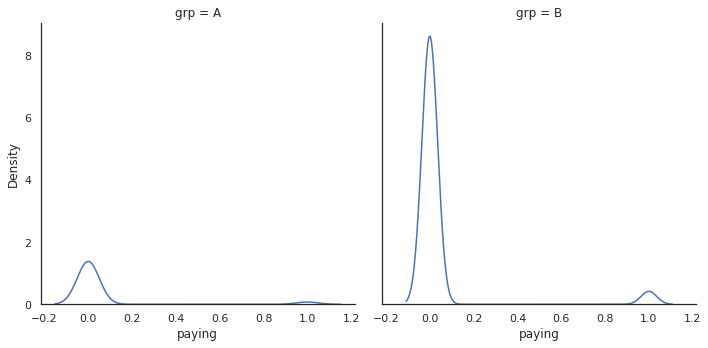

In [53]:
sns.set(rc={'figure.figsize': (12, 6)}, style="white")

sns.displot(data=data_all_corr, x='paying', kind='kde', col="grp")

### Выводы:
- распределения ассиметричные
- есть выбросы
- размеры выборок отличаются

Для проверки гипотез будет пользоваться методом бутстрап, и еще проверим методом Манна-Уитни, который также применяется для выборок с большими выбросами

In [54]:
control = data_A['paying']
target = data_B['paying']

res_mw = mannwhitneyu(control, target)
    
res_b_npmean = get_bootstrap(control, target, statistic=np.mean)

print(f'Boot mean: {res_b_npmean["p_value"]}, MW: {res_mw.pvalue}')

Boot mean: 0.20364520494572003, MW: 0.4455071016631552


### Выводы:
Оба теста показали p_value > 0.05,   
следовательно мы **принимаем нулевую гипотезу**, что **конверсия в оплату между контрольной и целевой группой статзначимо не изменилась**, пользователи не стали покупать статзначимо реже по время проведения эксперимента по тестированию новой механики оплаты услуг на сайте

***

### Вторая гипотеза
Н0 - Средний доход от 1 платящего пользователя не изменился   
Н1 - Средний доход от 1 платящего пользователя изменился

&darr; делаем выборку где grp == "A" и rev > 0 &darr;    

In [55]:
data_A_2 = data_all_corr.query('grp == "A" and rev > 0')
data_A_2.head()

,grp,id,rev,paying
62,A,1184303,1530.0,1
99,A,720651,1980.0,1
306,A,4337103,580.0,1
392,A,332387,2910.0,1
439,A,1659434,690.0,1


&darr;  делаем выборку где grp == "B" и rev > 0 &darr;  

In [56]:
data_B_2 = data_all_corr.query('grp == "B" and rev > 0')
data_B_2.head()

,grp,id,rev,paying
67,B,3354191,1900.0001,1
77,B,3278734,1900.0000,1
193,B,1232221,1900.0000,1
195,B,3821501,1900.0000,1
211,B,1036096,1900.0000,1


&darr; смотрим описательные статистики &darr;    

In [57]:
print(np.mean(data_A_2['rev']), np.mean(data_B_2['rev']))
print(np.median(data_A_2['rev']), np.median(data_B_2['rev']))
print(np.std(data_A_2['rev']), np.std(data_B_2['rev']))

933.5897435897435 1257.8789920382164
585.0 1140.0
914.016683850106 789.6039116220195


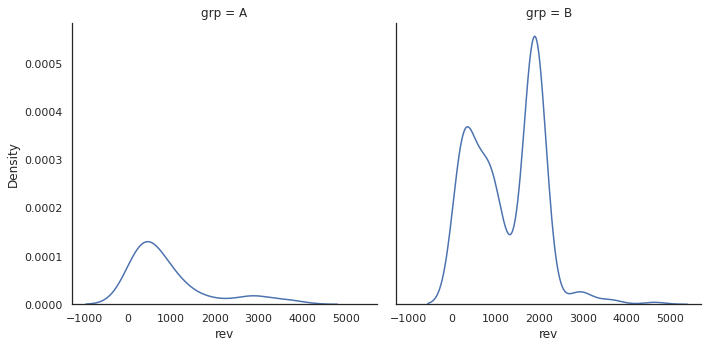

In [58]:
sns.set(rc={'figure.figsize': (12, 6)}, style="white")

sns.displot(data=data_all_corr[(data_all_corr.rev > 0)], x='rev', kind='kde', col="grp")

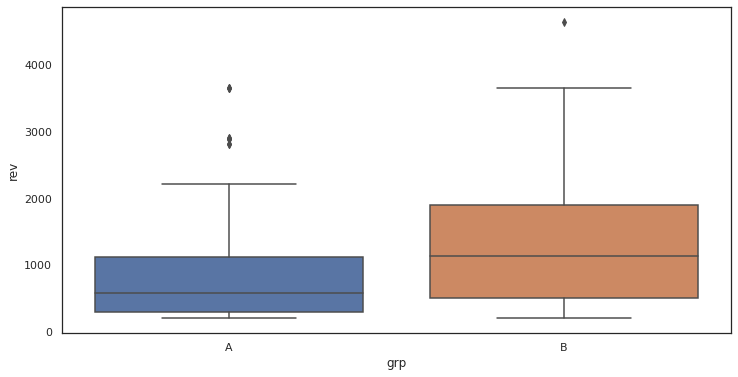

In [59]:
sns.set(rc={'figure.figsize': (12, 6)}, style="white")

sns.boxplot(data=data_all_corr[(data_all_corr.rev > 0)], x="grp", y="rev")

### Выводы:
- распределения ассиметричные  
- есть выбросы
- размеры выборок отличаются

Для проверки гипотез будет пользоваться методом бутстрап, и еще проверим методом Манна-Уитни, который также применяется для выборок с большими выбросами

In [60]:
control = data_A_2['rev']
target = data_B_2['rev']

res_mw = mannwhitneyu(control, target)

res_b_npmean = get_bootstrap(control, target, statistic=np.mean)    

print(f'Boot mean: {res_b_npmean["p_value"]}, MW: {res_mw.pvalue}')

Boot mean: 2.2791825018476717e-06, MW: 0.0002511393831406922


### Выводы:
Оба теста показали p_value < 0.05,   
следовательно мы отклоняем нулевую гипотезу и **принимаем альтернативную гипотезу**, что **средний доход на 1 платящего пользователя статзначимо изменился**, пользователи стали покупать на больший чек на сайте во время проведения эксперимета по тестированию новой механики оплаты услуг на сайте

***

# Итоговый вывод:


#### 1: конверсия в оплату между контрольной и целевой группой статзначимо не изменилась
пользователи не стали покупать статзначимо реже или чаще по время проведения эксперимента по тестированию новой механики оплаты услуг на сайте
#### 2: средний доход на 1 платящего пользователя статзначимо изменился
пользователи стали покупать на статзначимо больший чек на сайте во время проведения эксперимета по тестированию новой механики оплаты услуг на сайте

### Стоит ли запускать новую механику на всех пользователей?
На основании имеющихся данных и результатов анализа: **запускать новую механику на всех пользователей не стоит**. 

Потому что по имеющимся данным пользователи не стали покупать статзначимо чаще (а даже напротив, конверсия уменьшилась), но стали покупать на больший чек, что тоже может не иметь отношения к новой механике оплаты, так как задача скорее всего была увеличить конверсию в покупку, а на средний чек больше влияют другие механики (удобство поиска и фильтрации, предложения по сопутсвующим товарам и тп)